In [1]:
# Create a Simulate Environment

# Imports

In [619]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import os



%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from environment import LinearArray
from audio_datasets import YesNoDataset
from beamformer import DAS_beamformer,MVDR_beamformer, apply_beamformer, get_directivity

## Linear Array

In [689]:
M = 8
L = 20000
d = 0.1
fs = 8000
lin_arr = LinearArray(M,L,d,fs)
print(lin_arr.__len__())

0


In [ ]:
# Load signal

s1 = 1*torch.sin(2*np.pi *90* 1/fs*torch.arange(0,L))
s2 = 1*torch.sin(2*np.pi *70* 1/fs*torch.arange(0,L))
s3 = 3*torch.sin(2*np.pi *200* 1/fs*torch.arange(0,L))

sources = [s1]
thetas = [20]

for i in range(len(sources)):
  lin_arr.add_signal(sources[i],theta=thetas[i])

target_i = 0

torch.Size([20000]) torch.Size([257, 79])


Text(0.5, 1.0, 'Spectral Steering (Phase)')

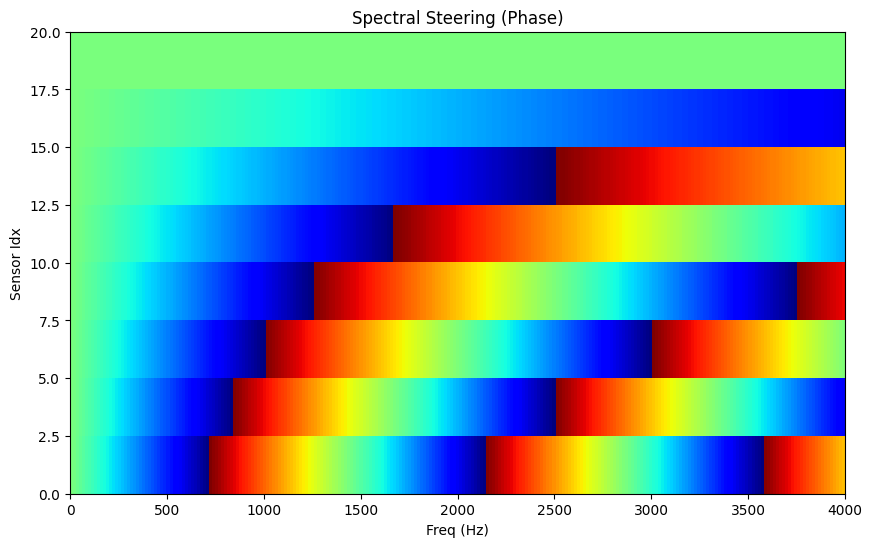

In [710]:
# Test S_Vec
s_vec = lin_arr.eval_svec(thetas[0])

f,ax = plt.subplots(figsize=(10,6))

ax.imshow(torch.angle(s_vec),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Sensor Idx')
ax.set_title('Spectral Steering (Phase)')

torch.Size([1, 8, 257])


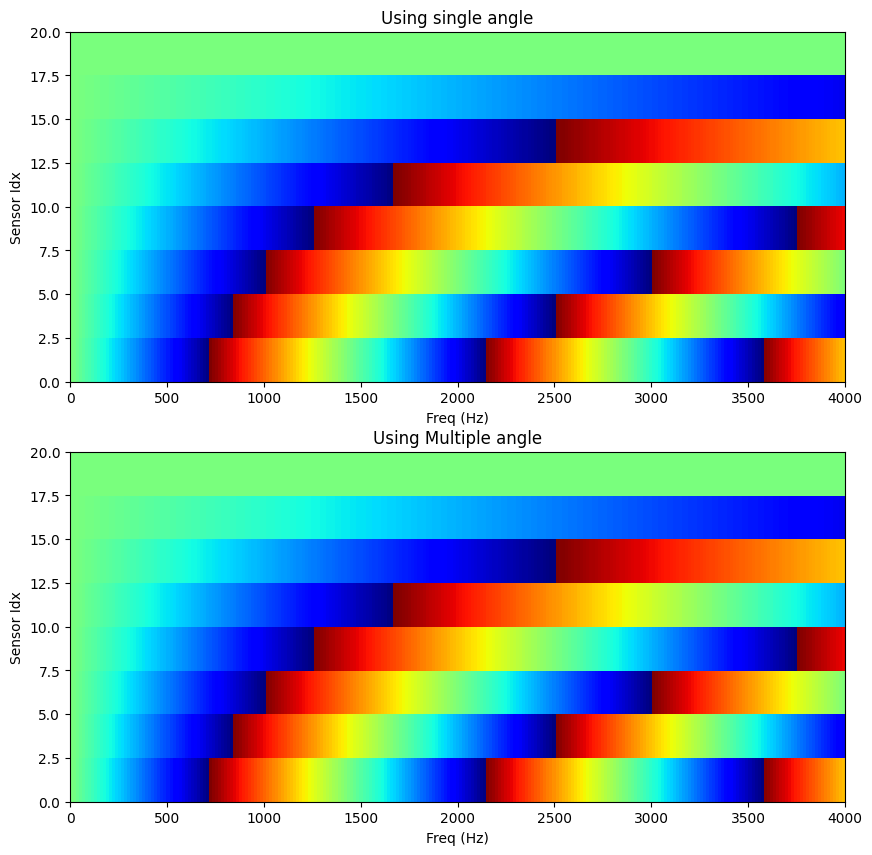

In [711]:
# Test Multiple angles s_vec and index for 30 deg
s_vec_multi = lin_arr.eval_svec_multiangle(thetas)
print(s_vec_multi.shape)

# Plot if there is any discrepancy
f,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(torch.angle(s_vec),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[0].set_title('Using single angle')
ax[1].imshow(torch.angle(s_vec_multi[0,:,:]),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[1].set_title('Using Multiple angle')
for i in range(len(ax)):
  ax[i].set_xlabel('Freq (Hz)')
  ax[i].set_ylabel('Sensor Idx')


In [713]:
# Sensor Reading Test
sensor_output = lin_arr.read_sensor()

print(sensor_output.shape) # M, L'

torch.Size([8, 19968])


(0.0, 240.0)

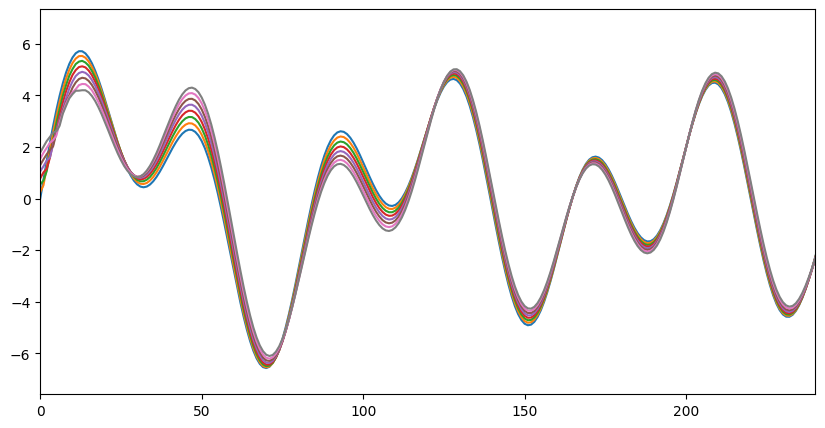

In [714]:
# plot the multi sensor data
fig,ax = plt.subplots(figsize=(10,5))

for m in range(M):
  x = sensor_output[m,:]
  ax.plot(x)

ax.set_xlim([0,240])

In [694]:
# Apply DAS
das = DAS_beamformer(lin_arr=lin_arr, theta_target=thetas[target_i])

output_signal = apply_beamformer(X,das)

IndexError: list index out of range

In [682]:
# get directivity
D = torch.log(get_directivity(lin_arr,das,n_thetas=200))
print(das.shape)
plt.imshow(D.transpose(-1,-2),aspect='auto',extent=[0,180,0,fs/2], clim=(-10,-7),cmap = 'jet')

/home/ms4/Desktop/research/beamforming/./src/environment.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faxis = torch.linspace(0,self.fs//2,self.Nf) # Size (F)


RuntimeError: The size of tensor a (200) must match the size of tensor b (20) at non-singleton dimension 2

Text(0.5, 1.0, 'DAS Output')

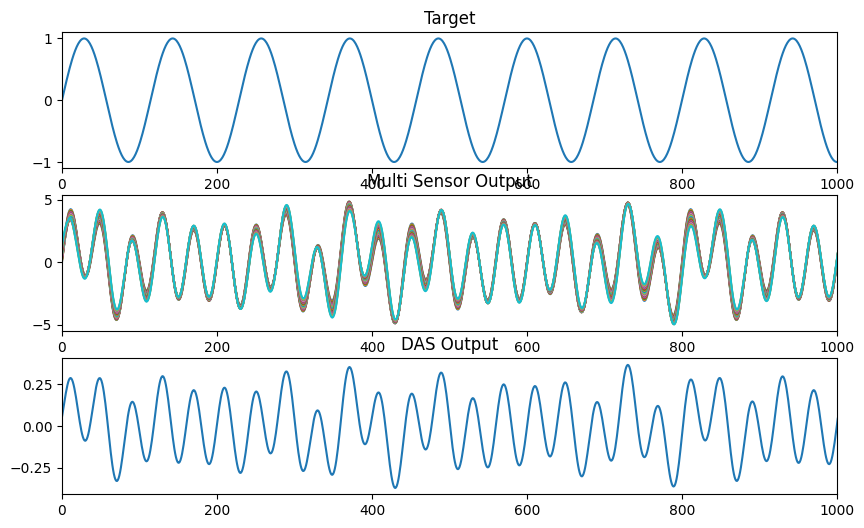

In [666]:
f,ax = plt.subplots(3,1,figsize=(10,6))
#for i in range(M):
   #ax[0].plot(X[i,:])

ax[0].plot(sources[i])
for i in range(M):
    ax[1].plot(X[i,:])
ax[2].plot(output_signal)


ax[0].set_xlim([0,1000])
ax[1].set_xlim([0,1000])
ax[2].set_xlim([0,1000])


ax[0].set_title('Target')
ax[1].set_title('Multi Sensor Output')
ax[2].set_title('DAS Output')

## MVDR

torch.Size([20, 200, 257]) torch.Size([257, 20])
torch.Size([257, 20])


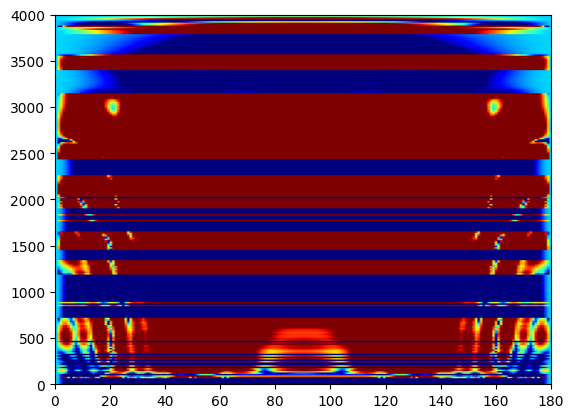

In [552]:
w = MVDR_beamformer(lin_arr,thetas[target_i])
# get directivity
D = torch.log(get_directivity(lin_arr,w,n_thetas=200))
print(w.shape)
plt.imshow(D.transpose(-1,-2),aspect='auto',extent=[0,180,0,fs/2], clim=(-1,2),cmap = 'jet')

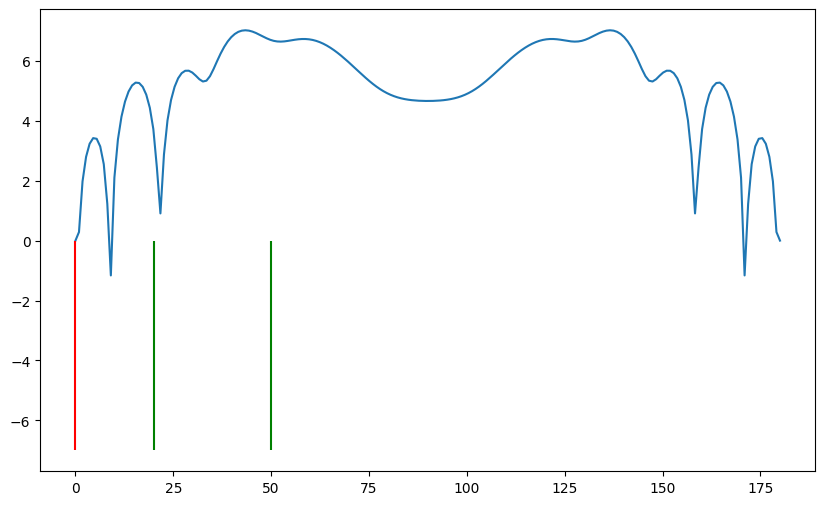

In [553]:
f,ax = plt.subplots(figsize=(10,6))
ax.plot(np.linspace(0,180,D.shape[0]),D[:,128])
for i in range(len(thetas)):
  if i == target_i:
    ax.vlines(thetas[i],ymin=-7,ymax = 0,color='r')
  else:
    ax.vlines(thetas[i],ymin=-7,ymax = 0,color='g')
    
  

In [529]:
# apply the beamformer
output_signal = apply_beamformer(X,w)

Text(0.5, 1.0, 'MVDR Ouput')

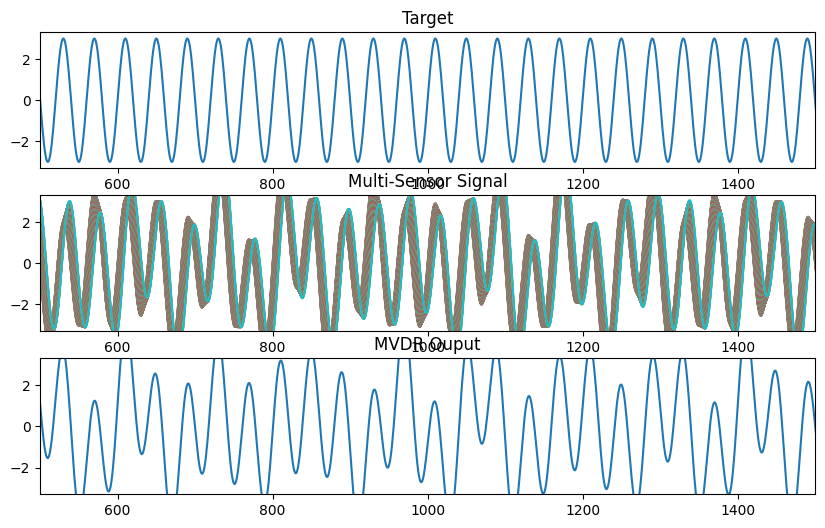

In [530]:
f,ax = plt.subplots(3,1,figsize=(10,6))
#for i in range(M):
   #ax[0].plot(X[i,:])

ax[0].plot(sources[target_i])
for i in range(M):
    ax[1].plot(X[i,:])
ax[2].plot(output_signal)

ylim = ax[0].get_ylim()
for i in range(len(ax)):
    ax[i].set_xlim([500,1500])
    ax[i].set_ylim(ylim)

ax[0].set_title('Target')
ax[1].set_title('Multi-Sensor Signal')
ax[2].set_title('MVDR Ouput')